In [66]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
from fastf1 import plotting
import fastf1 as ff1


In [67]:
img_dir = '../img/'

# Setup plotting
plotting.setup_mpl()

# Enable the cache
ff1.Cache.enable_cache('../../cache')

# Get rid of some pandas warnings that are not relevant for us at the moment
pd.options.mode.chained_assignment = None

compound_colors = {
    'SOFT': '#FF3333',
    'MEDIUM': '#FFF200',
    'HARD': '#EBEBEB',
    'INTERMEDIATE': '#39B54A',
    'WET': '#00AEEF',
}


In [68]:
# Load the session data
race = ff1.get_session(2022, 'Belgium', 'R')

# Get the laps
laps = race.load_laps(with_telemetry=True)

# laps = pd.DataFrame(laps)
# laps.to_csv('../data/laps_BelgianGP2022.csv', index=False)


/home/ilias/anaconda3/lib/python3.9/site-packages/fastf1/core.py:1127: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Belgian Grand Prix - Race [v2.2.9]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '63', '14', '16', '31', '5',

In [69]:
driver_stints = laps[['Driver', 'Stint', 'Compound', 'LapNumber']].groupby(
    ['Driver', 'Stint', 'Compound']).count().reset_index()

driver_stints = driver_stints.rename(columns={'LapNumber': 'StintLength'})
driver_stints = driver_stints.sort_values(by=['Stint'])


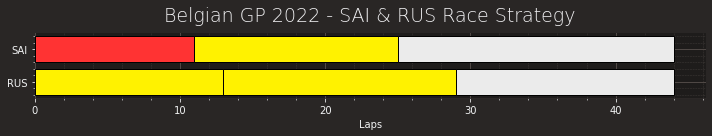

In [70]:
plt.rcParams["figure.figsize"] = [10, 2]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

# drivers = race.results['Abbreviation'].head(6)
drivers = ['SAI', 'RUS']

ticks_x = []
for driver in drivers:
    stints = driver_stints.loc[driver_stints['Driver'] == driver]

    previous_stint_end = 0
    for _, stint in stints.iterrows():
        plt.barh(
            [driver],
            stint['StintLength'],
            left=previous_stint_end,
            color=compound_colors[stint['Compound']],
            edgecolor="black"
        )
        previous_stint_end = previous_stint_end + stint['StintLength']


plt.title(f'Belgian GP 2022 - SAI & RUS Race Strategy')
plt.xlabel('Laps')
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig(img_dir + 'strategy_sai_rus_belgianGP2022.png', dpi=300)
plt.show()


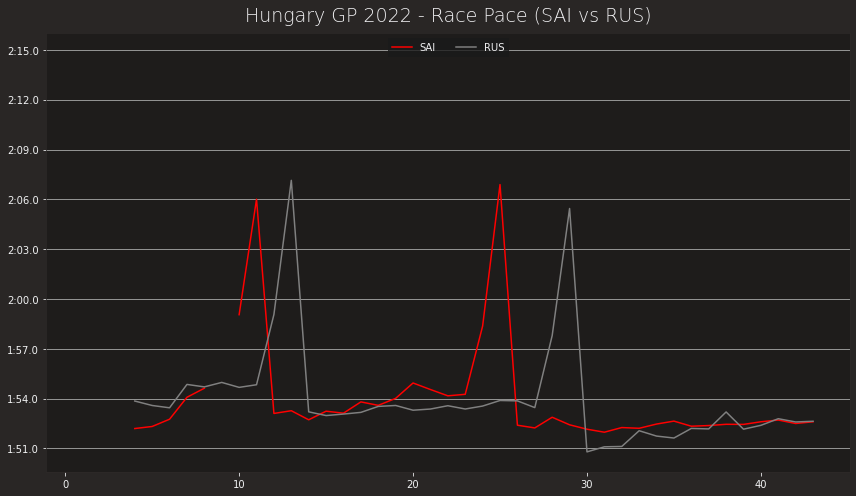

In [71]:
# laps_driver1 = laps.pick_driver('VER')
laps_driver3 = laps.pick_driver('RUS')
laps_driver4 = laps.pick_driver('SAI')

# laps_driver1['RaceLapNumber'] = laps_driver1['LapNumber'] - 1
laps_driver3['RaceLapNumber'] = laps_driver3['LapNumber'] - 1
laps_driver4['RaceLapNumber'] = laps_driver4['LapNumber'] - 1


plt.rcParams['figure.figsize'] = [12, 7]

# plt.plot(laps_driver1['RaceLapNumber'],
#          laps_driver1['LapTime'], label='VER', color='blue')
plt.plot(laps_driver4['RaceLapNumber'],
         laps_driver4['LapTime'], label='SAI', color='red')
plt.plot(laps_driver3['RaceLapNumber'],
         laps_driver3['LapTime'], label='RUS', color='grey')


# plt.set(ylabel='Laptime', xlabel='Lap')
plt.title(f'Hungary GP 2022 - Race Pace (SAI vs RUS)')
plt.legend(loc="upper center", ncol=3)
plt.gca().yaxis.grid(True)
plt.savefig(img_dir + 'race_pace_sai_rus_belgianGP2022.png', dpi=300)
plt.show()


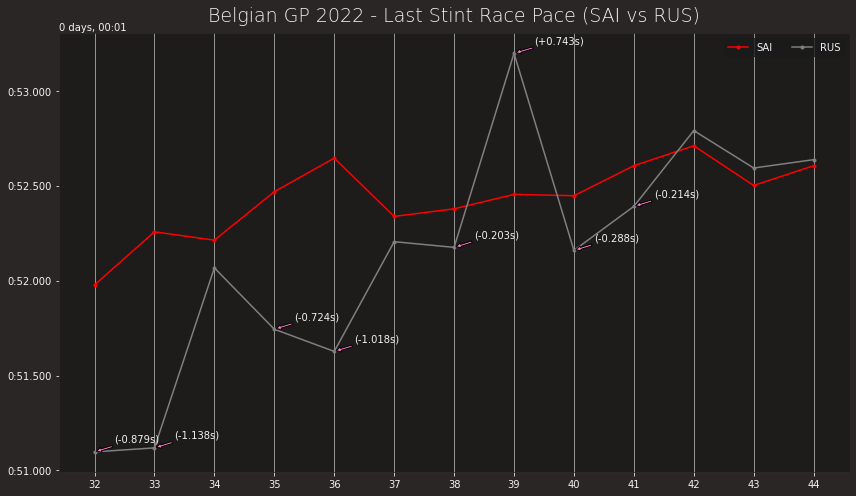

In [72]:
laps_driver3 = laps_driver3[laps_driver3['RaceLapNumber'] >= 31]
laps_driver4 = laps_driver4[laps_driver4['RaceLapNumber'] >= 31]
# laps_driver3 = laps_driver3[laps_driver3['Stint'] == 3]
# laps_driver4 = laps_driver4[laps_driver4['Stint'] == 3]

plt.rcParams['figure.figsize'] = [12, 7]

plt.plot(laps_driver4['LapNumber'],
         laps_driver4['LapTime'], label='SAI', color='red', marker='.')
plt.plot(laps_driver3['LapNumber'],
         laps_driver3['LapTime'], label='RUS', color='grey', marker='.')

# plt.set(ylabel='Laptime', xlabel='Lap')
plt.title(f'Belgian GP 2022 - Last Stint Race Pace (SAI vs RUS)')
plt.xticks(laps_driver4['LapNumber'].values.tolist())
plt.legend(loc="upper right", ncol=3)
plt.gca().xaxis.grid(True)
# plt.grid()

i = 0
for _ in laps_driver4['LapNumber']:
    
    diff = laps_driver3['LapTime'].values[i] - laps_driver4['LapTime'].values[i]
    diff = pd.Timedelta(diff)

    # if diff < 0:
    if diff.days == -1:
        neg = True
        diff = abs(laps_driver3['LapTime'].values[i] - laps_driver4['LapTime'].values[i])
        diff = pd.Timedelta(diff)

    s = diff.seconds
    ms = int(diff.microseconds / 1000)
    
    if diff > pd.Timedelta(seconds=0.2):
        if neg:
            diff_format = '(-{:01}.{:03}s)'.format(s % 60, ms)
        else:
            diff_format = '(+{:01}.{:03}s)'.format(s % 60, ms)
        plt.annotate(diff_format,
                xy=(laps_driver3['LapNumber'].values[i], laps_driver3['LapTime'].values[i]),
                xycoords='data',
                xytext=(20, 10),
                textcoords='offset points',
            arrowprops=dict(arrowstyle='simple'))
    neg = False
    i+=1


plt.savefig(img_dir + 'race_pace_sai_rus_last_stint_belgianGP2022.png', dpi=300)
plt.show()
